In [ ]:
!pip install bambi

# Load data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

plt.style.use("ggplot")
figsize(20, 10)

In [2]:
import arviz as az
import bambi as bmb

In [3]:
df = pd.read_csv("survey_results_public.csv")

/home/khuyen/Data-science/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (8,12,13,14,15,16,50,51,52,53,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
df.FormalEducation = df.FormalEducation.map(
    {
        "Bachelor’s degree (BA, BS, B.Eng., etc.)": "Bachelor’s degree",
        "Master’s degree (MA, MS, M.Eng., MBA, etc.)": "Master’s degree",
        "Some college/university study without earning a degree": "Some college/university, no degree",
        "Associate degree": "Associate degree",
        "Other doctoral degree (Ph.D, Ed.D., etc.)": "Doctoral degree",
        "Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)": "Secondary school",
        "Professional degree (JD, MD, etc.)": "Professional degree",
        "Primary/elementary school": "Primary/elementary school",
        "I never completed any formal education": "no formal education",
    }
)

In [5]:
companySize_to_interval = {
    "Fewer than 10 employees": pd.Interval(0, 10),
    "10 to 19 employees": pd.Interval(10, 19),
    "20 to 99 employees": pd.Interval(20, 99),
    "100 to 499 employees": pd.Interval(100, 499),
    "500 to 999 employees": pd.Interval(500, 999),
    "1,000 to 4,999 employees": pd.Interval(1000, 4999),
    "5,000 to 9,999 employees": pd.Interval(5000, 9999),
    "10,000 or more employees": pd.Interval(10000, float("inf")),
}

df.CompanySize = df.CompanySize.map(companySize_to_interval)

# Salary

In [6]:
sample = df.query(
    "Country == 'United States' & Employment == 'Employed full-time' & Student == 'No'"
)

In [7]:
normal_salary = sample[sample["ConvertedSalary"] < 300_000].copy()

In [8]:
bins = [0, 25_000, 50_000, 75_000, 100_000, 125_000, 150_000, 300_000]

normal_salary["Salary Range"] = pd.cut(
    normal_salary.dropna(subset=["ConvertedSalary"])["ConvertedSalary"], bins=bins
)

salary_groupby = normal_salary.groupby("Salary Range").agg({"Respondent": "count"})
salary_groupby

,Respondent
Salary Range,
"(0, 25000]",62
"(25000, 50000]",514
"(50000, 75000]",2082
"(75000, 100000]",2625
"(100000, 125000]",2250
"(125000, 150000]",1521
"(150000, 300000]",1110


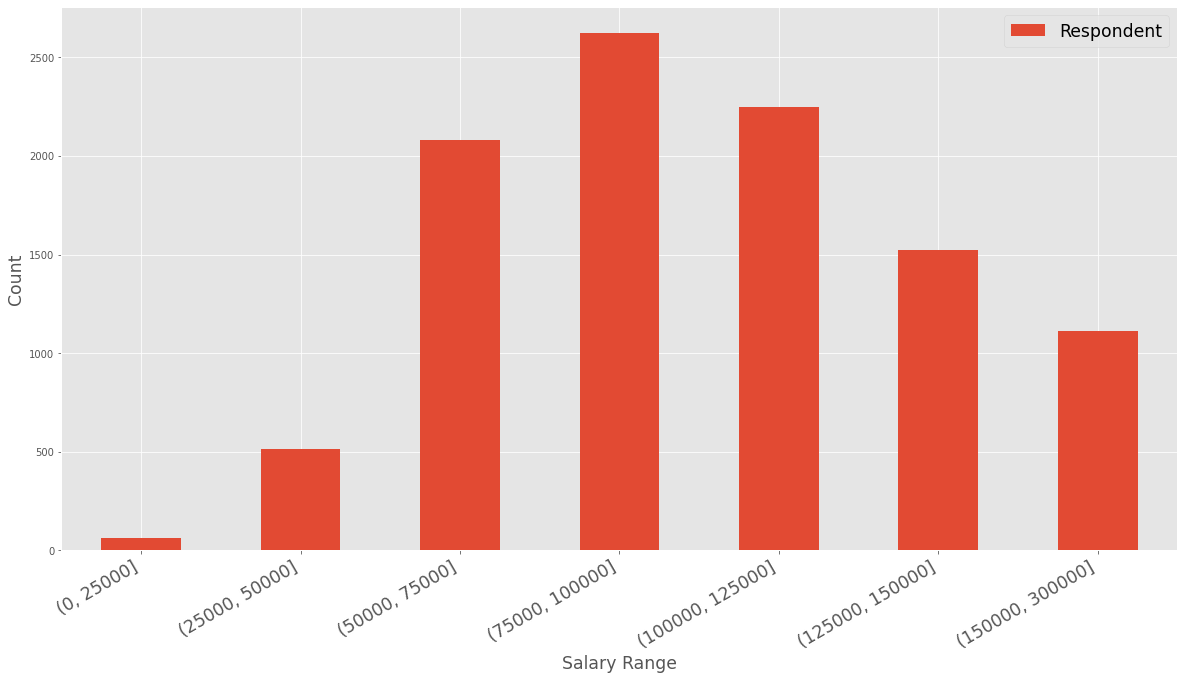

In [9]:
salary_groupby.plot(kind="bar")
plt.xticks(rotation=30, ha="right", fontsize="xx-large")
plt.legend(fontsize="xx-large")
plt.xlabel("Salary Range", fontsize="xx-large")
plt.ylabel("Count", fontsize="xx-large")
plt.show()

## Salary by Years Coding

In [10]:
normal_salary.YearsCoding.head(10)

6           9-11 years
8     30 or more years
23         18-20 years
32           6-8 years
33           3-5 years
35         12-14 years
43          9-11 years
46         15-17 years
47           3-5 years
49         15-17 years
Name: YearsCoding, dtype: object

In [11]:
def str_to_interval(text: str):
    if isinstance(text, str):
        years = text.split()[0].split("-")
        if len(years) == 2:
            return pd.Interval(int(years[0]), int(years[1]))
        else:
            return pd.Interval(int(years[0]), float("inf"))

    return text

In [12]:
normal_salary.YearsCoding = normal_salary.YearsCoding.apply(str_to_interval)

In [13]:
years_sorted = normal_salary.dropna(
    subset=["ConvertedSalary", "YearsCoding"]
).sort_values(by="YearsCoding")

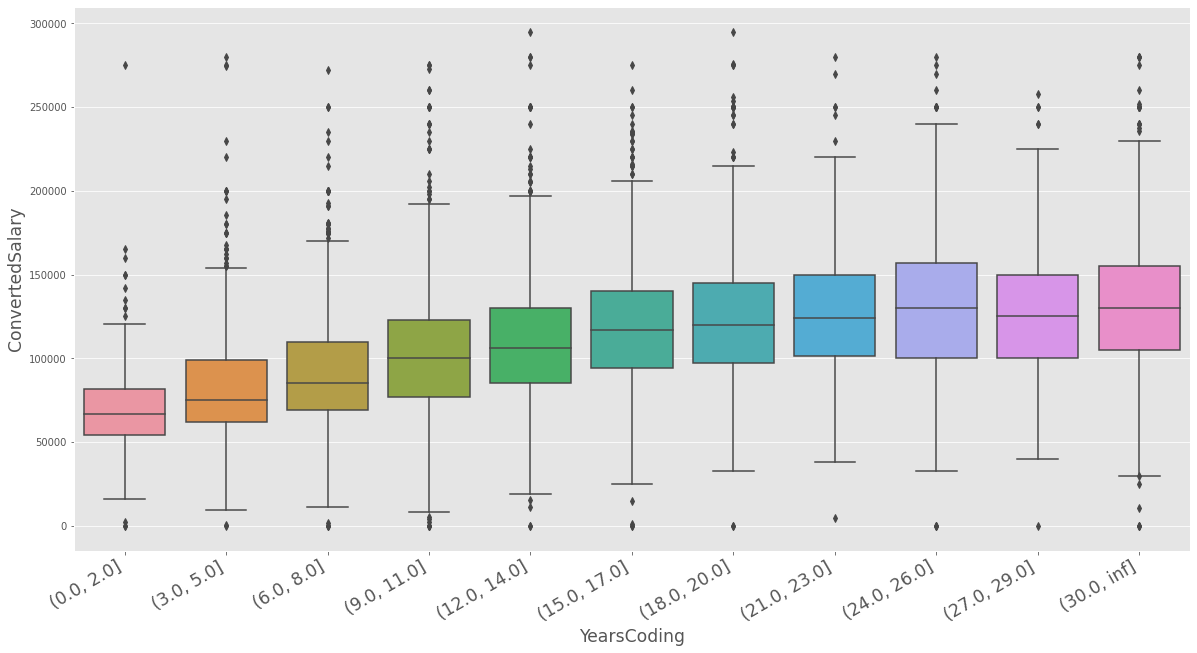

In [14]:
sns.boxplot(data=years_sorted, x="YearsCoding", y="ConvertedSalary")
plt.xticks(rotation=30, ha="right", fontsize="xx-large")
plt.xlabel("YearsCoding", fontsize="xx-large")
plt.ylabel("ConvertedSalary", fontsize="xx-large")
plt.show()

## Bayesian t-test on 2 Different Years of Experience

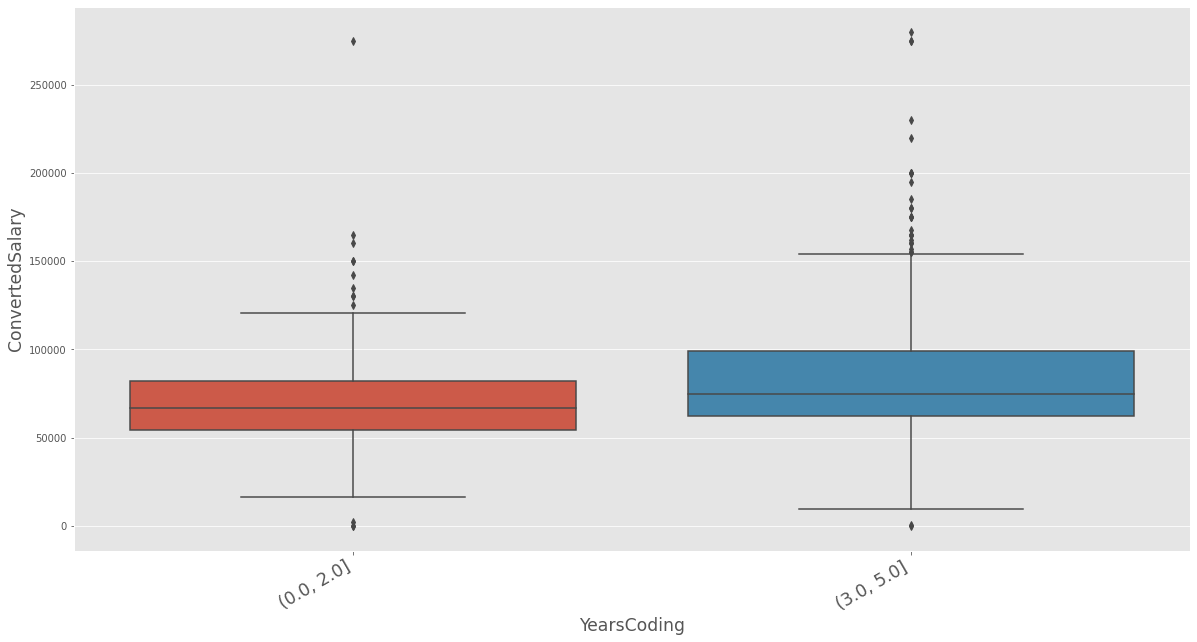

In [15]:
# Filter
sample1 = years_sorted[
    (years_sorted.YearsCoding == pd.Interval(0, 2))
    | (years_sorted.YearsCoding == pd.Interval(3, 5))
]

# visualize
sns.boxplot(data=sample1, x="YearsCoding", y="ConvertedSalary")
plt.xticks(rotation=30, ha="right", fontsize="xx-large")
plt.xlabel("YearsCoding", fontsize="xx-large")
plt.ylabel("ConvertedSalary", fontsize="xx-large")
plt.show()

In [16]:
sample1.YearsCoding = sample1.YearsCoding.astype(str)

/home/khuyen/Data-science/venv/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [17]:
# Build model
model1 = bmb.Model("ConvertedSalary ~ YearsCoding", sample1)
result1 = model1.fit(random_seed=0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ConvertedSalary_sigma, Intercept, YearsCoding]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [18]:
az.summary(result1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,70118.642,1437.951,67456.406,72765.687,20.331,14.379,4995.0,3164.0,1.0
"YearsCoding[(3.0, 5.0]]",11400.077,1591.621,8418.925,14348.040,22.663,16.159,4928.0,3165.0,1.0
ConvertedSalary_sigma,29300.871,473.605,28404.705,30135.009,6.347,4.488,5533.0,3054.0,1.0


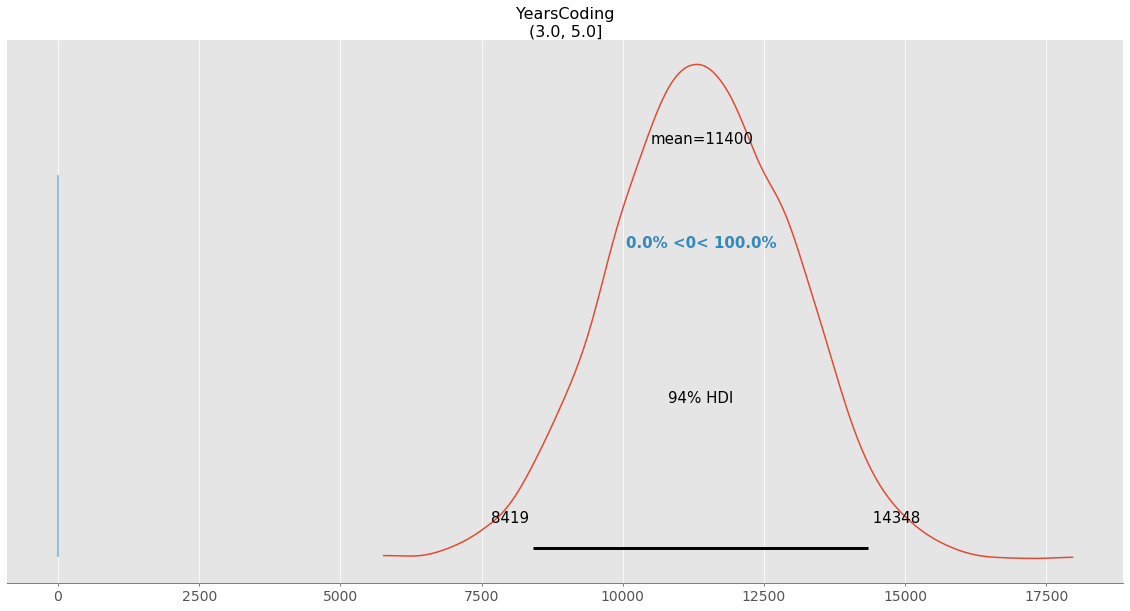

<IPython.core.display.Javascript object>

In [68]:
az.plot_posterior(result1.posterior["YearsCoding"], ref_val=0)

In [21]:
(result1.posterior["YearsCoding"] > 1).values.mean()

1.0

## Bayesian t-test on Multiple Years of Experience

In [22]:
years_sorted.YearsCoding = years_sorted.YearsCoding.astype(str)

In [23]:
all_model = bmb.Model("ConvertedSalary ~ YearsCoding", years_sorted)
all_results = all_model.fit(random_seed=0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ConvertedSalary_sigma, Intercept, YearsCoding]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [26]:
yearsCoding_summary = (
    az.summary(all_results)
    .drop(["ConvertedSalary_sigma", "Intercept"])
    .sort_values(by="mean")
)

yearsCoding_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"YearsCoding[(3.0, 5.0]]",11421.352,1955.290,7740.252,14914.708,64.670,46.003,917.0,1529.0,1.0
"YearsCoding[(6.0, 8.0]]",20511.885,1959.721,16918.917,24131.242,65.276,46.318,909.0,1561.0,1.0
"YearsCoding[(9.0, 11.0]]",32234.830,1989.373,28712.400,36146.851,65.791,46.595,918.0,1309.0,1.0
"YearsCoding[(12.0, 14.0]]",40487.814,2061.214,36958.165,44664.510,66.404,47.087,969.0,1294.0,1.0
"YearsCoding[(15.0, 17.0]]",48725.524,2129.843,44705.878,52566.385,68.134,48.294,984.0,1504.0,1.0
"YearsCoding[(18.0, 20.0]]",52808.942,2132.268,49038.413,56969.853,68.557,48.492,970.0,1677.0,1.0
"YearsCoding[(21.0, 23.0]]",56866.539,2360.835,52524.786,61319.747,70.773,50.078,1117.0,1755.0,1.0
"YearsCoding[(27.0, 29.0]]",59974.662,3263.677,53671.924,66040.101,76.303,54.148,1822.0,2440.0,1.0
"YearsCoding[(24.0, 26.0]]",63224.745,2629.080,58216.359,67953.555,71.433,50.745,1357.0,1737.0,1.0
"YearsCoding[(30.0, inf]]",63348.904,2246.668,59193.453,67475.600,70.311,49.834,1024.0,1611.0,1.0


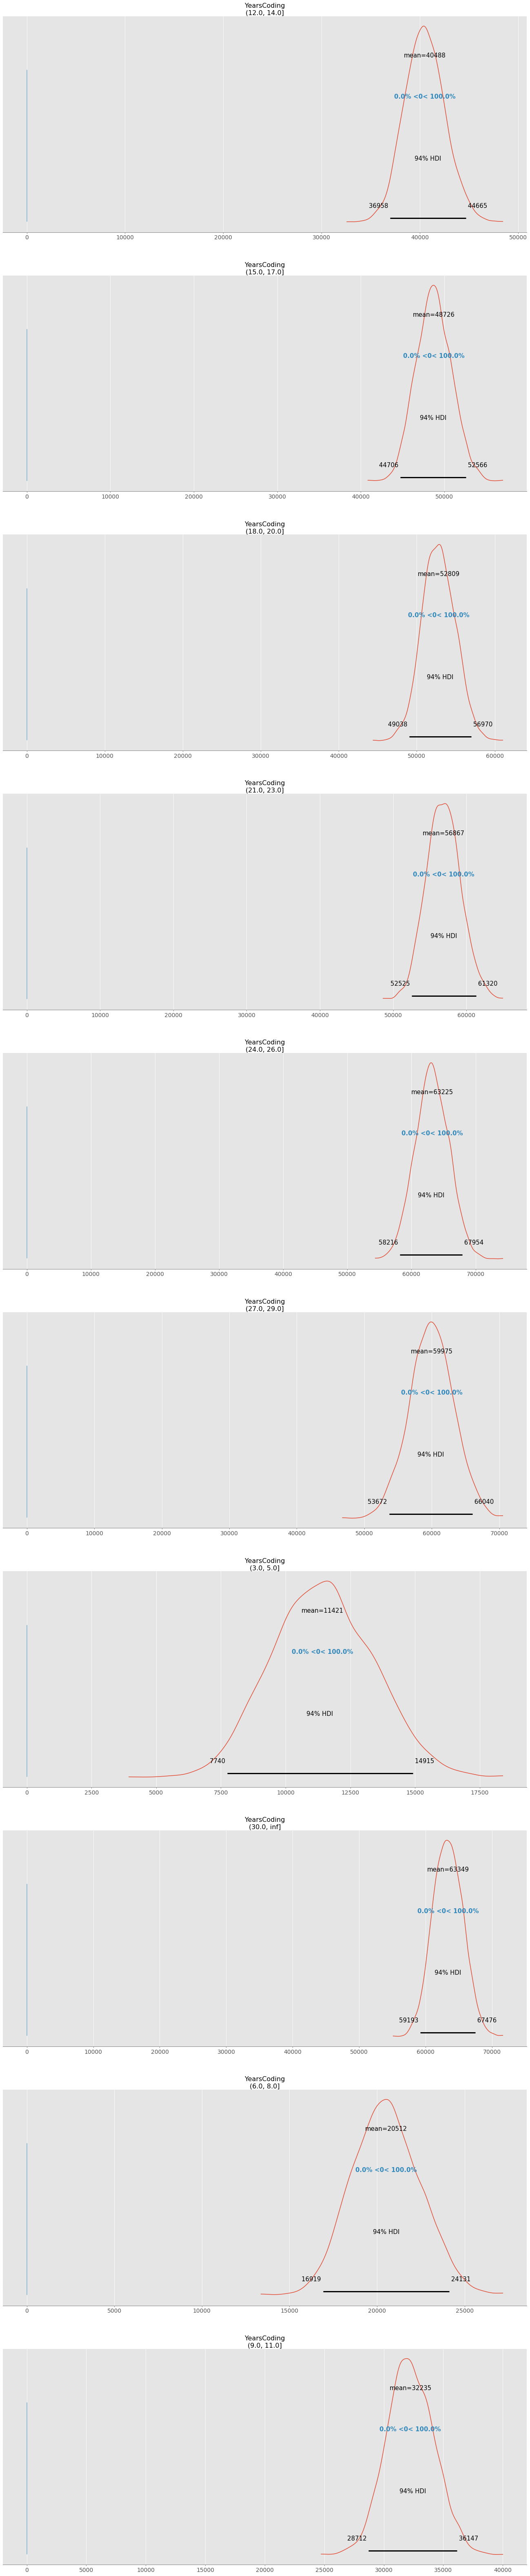

<IPython.core.display.Javascript object>

In [72]:
az.plot_posterior(all_results.posterior["YearsCoding"], ref_val=0, grid=(10, 1))

## Salary by Formal Education

In [15]:
ordered_degrees = [
    "no formal education",
    "Primary/elementary school",
    "Secondary school",
    "Some college/university, no degree",
    "Associate degree",
    "Bachelor’s degree",
    "Master’s degree",
    "Professional degree",
    "Doctoral degree",
]

normal_salary.FormalEducation = normal_salary.FormalEducation.astype("category")
normal_salary.FormalEducation.cat.set_categories(
    ordered_degrees, ordered=True, inplace=True
)

sort_by_education = normal_salary.dropna(
    subset=["ConvertedSalary", "FormalEducation"]
).sort_values(by="FormalEducation")

/home/khuyen/Data-science/venv/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


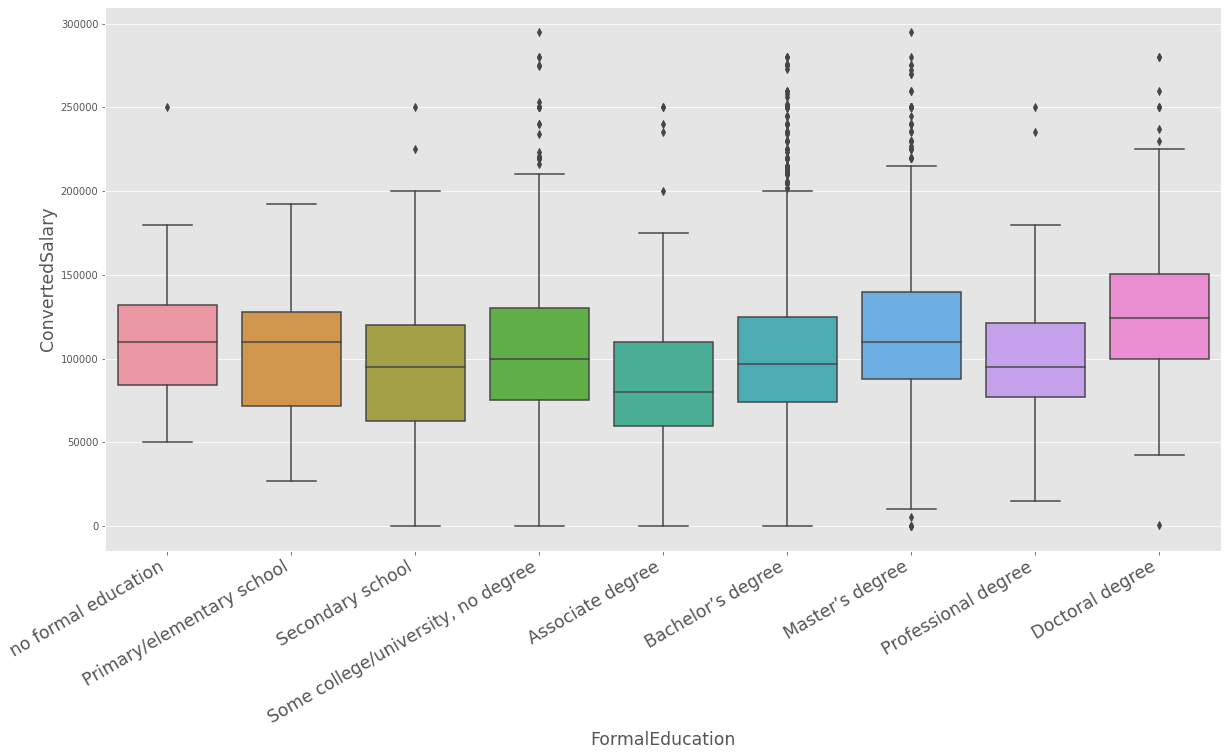

In [22]:
sns.boxplot(
    data=sort_by_education,
    x="FormalEducation",
    y="ConvertedSalary",
)
plt.xticks(rotation=30, ha="right", fontsize="xx-large")
plt.xlabel("FormalEducation", fontsize="xx-large")
plt.ylabel("ConvertedSalary", fontsize="xx-large")
plt.show()

## Salary by Company Size

In [24]:
size_sorted = normal_salary.dropna(
    subset=["ConvertedSalary", "CompanySize"]
).sort_values(by="CompanySize")

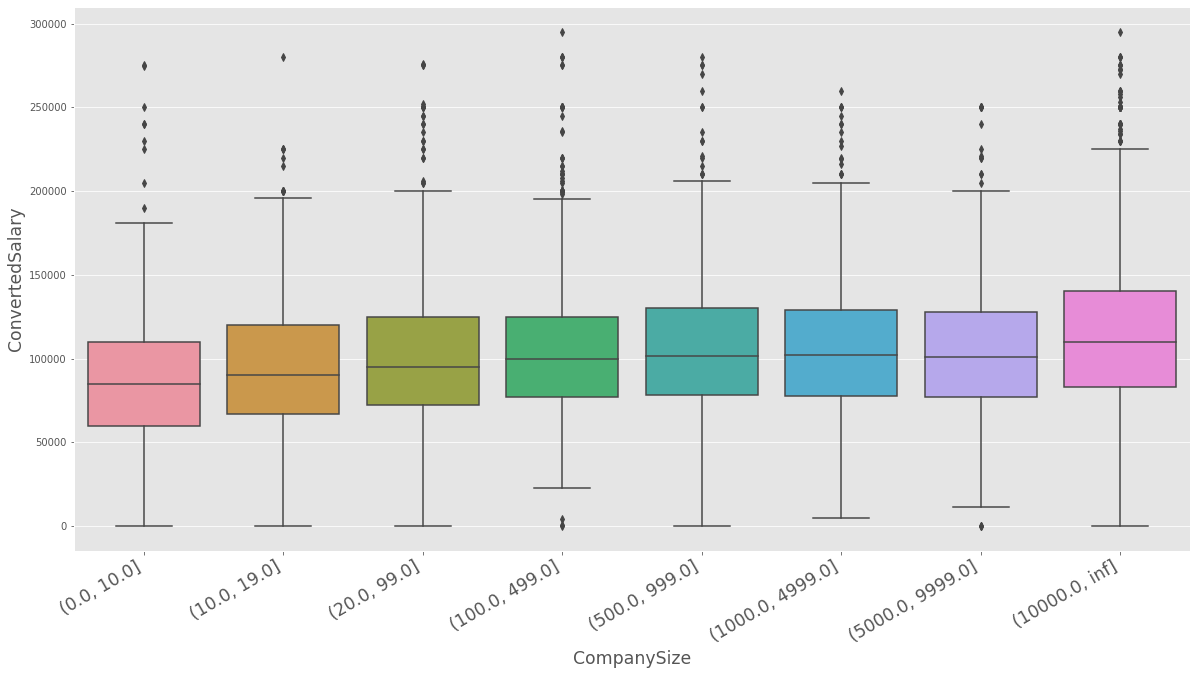

In [25]:
sns.boxplot(
    data=size_sorted,
    x="CompanySize",
    y="ConvertedSalary",
)
plt.xticks(rotation=30, ha="right", fontsize="xx-large")
plt.xlabel("CompanySize", fontsize="xx-large")
plt.ylabel("ConvertedSalary", fontsize="xx-large")
plt.show()

## Salary by Developer Type

In [18]:
def str_to_list(text: str):
    if isinstance(text, str):
        return text.split(";")
    return text

In [19]:
normal_salary["DevType"] = normal_salary.DevType.apply(str_to_list)

In [51]:
devtype = normal_salary.explode(column="DevType").dropna(
    subset=["ConvertedSalary", "DevType"]
)

<IPython.core.display.Javascript object>

In [52]:
sorted_dev = (
    devtype[["ConvertedSalary", "DevType"]]
    .groupby("DevType")
    .median()
    .sort_values(by="ConvertedSalary", ascending=False)
    .index
)

<IPython.core.display.Javascript object>

In [46]:
sorted_dev

CategoricalIndex(['Engineering manager', 'C-suite executive (CEO, CTO, etc.)',
                  'DevOps specialist', 'Product manager',
                  'Data scientist or machine learning specialist',
                  'Back-end developer',
                  'Desktop or enterprise applications developer',
                  'Educator or academic researcher',
                  'Embedded applications or devices developer',
                  'Full-stack developer', 'Game or graphics developer',
                  'Mobile developer', 'Front-end developer',
                  'System administrator', 'Database administrator',
                  'Marketing or sales professional',
                  'Data or business analyst', 'Designer',
                  'QA or test developer', 'Student'],
                 categories=['Back-end developer', 'C-suite executive (CEO, CTO, etc.)', 'Data or business analyst', 'Data scientist or machine learning specialist', 'Database administrator', 'Designer', 'De

<IPython.core.display.Javascript object>

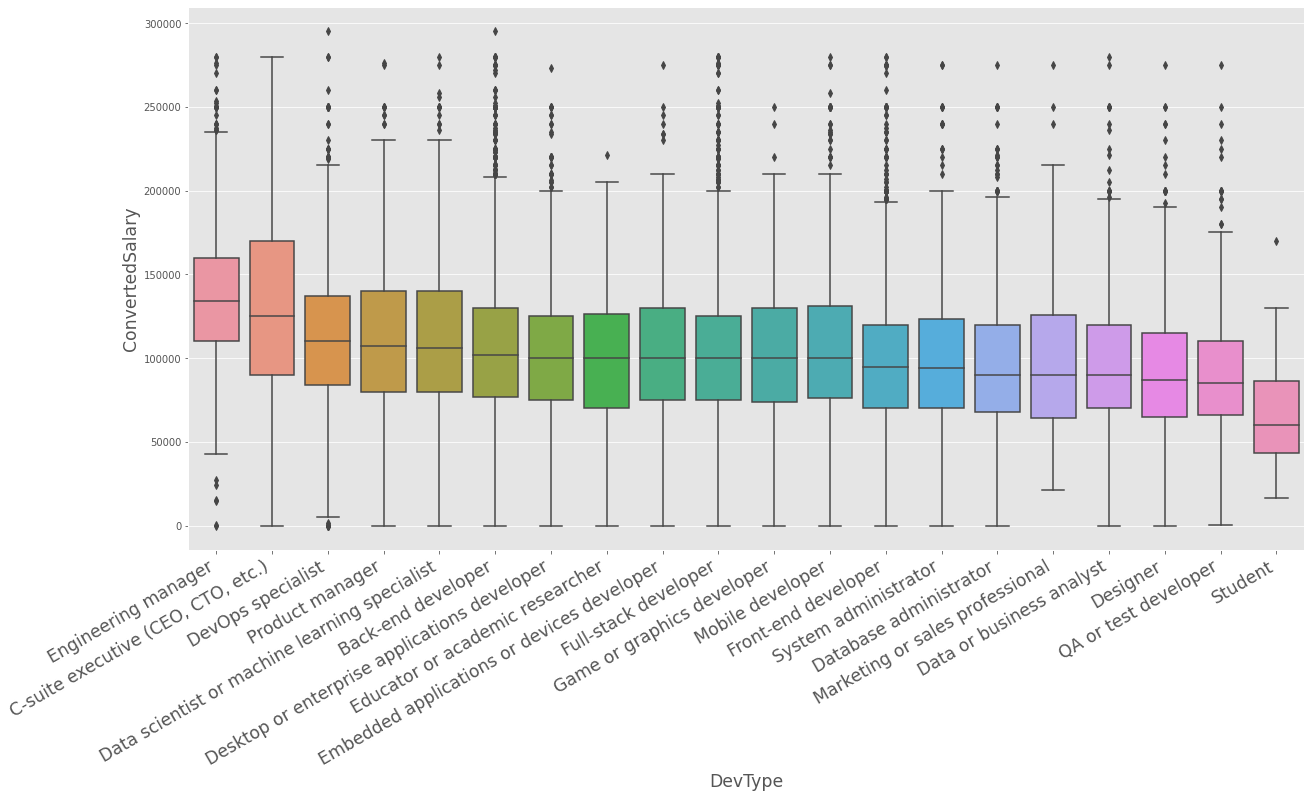

<IPython.core.display.Javascript object>

In [54]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=devtype, x="DevType", y="ConvertedSalary", order=sorted_dev)
plt.xticks(rotation=30, ha="right", fontsize="xx-large")
plt.xlabel("DevType", fontsize="xx-large")
plt.ylabel("ConvertedSalary", fontsize="xx-large")
plt.show()

### Salary of CEO by Company Size

In [58]:
ceo = devtype.query("DevType == 'C-suite executive (CEO, CTO, etc.)'").sort_values(
    by="CompanySize"
)

<IPython.core.display.Javascript object>

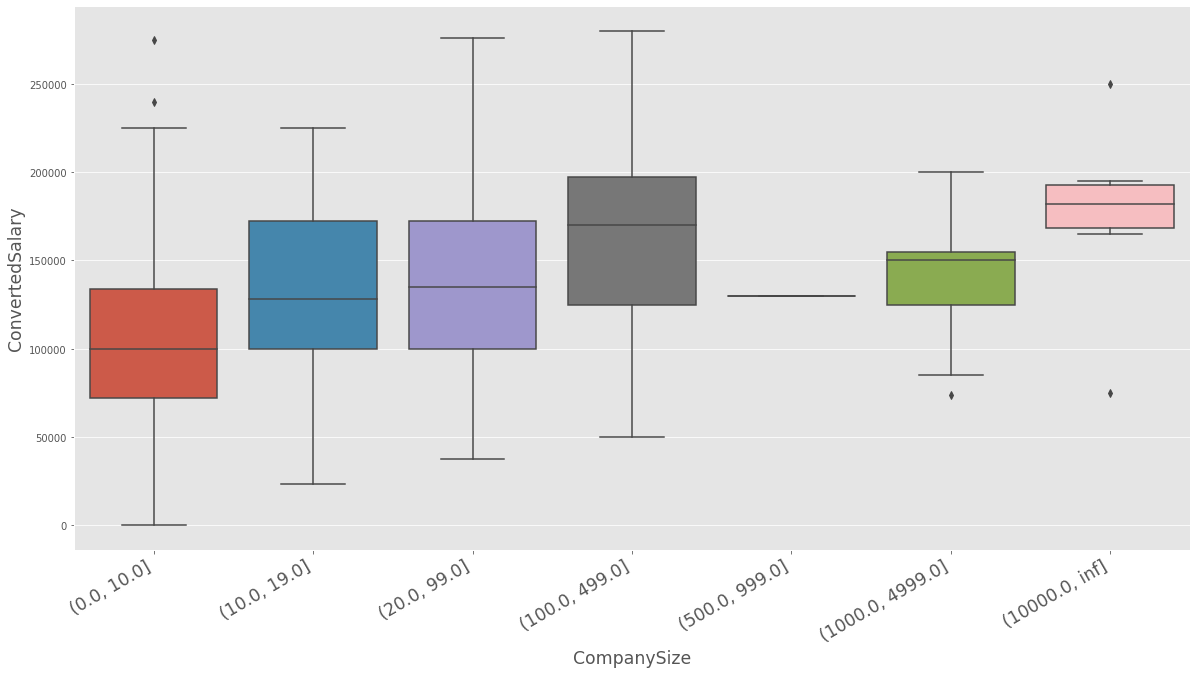

<IPython.core.display.Javascript object>

In [59]:
sns.boxplot(
    data=ceo,
    x="CompanySize",
    y="ConvertedSalary",
)
plt.xticks(rotation=30, ha="right", fontsize="xx-large")
plt.xlabel("CompanySize", fontsize="xx-large")
plt.ylabel("ConvertedSalary", fontsize="xx-large")
plt.show()

### Salary of Data Professionals by Company Size

In [343]:
ml = devtype.query(
    "DevType == 'Data scientist or machine learning specialist'"
).sort_values(by="CompanySize")

<IPython.core.display.Javascript object>

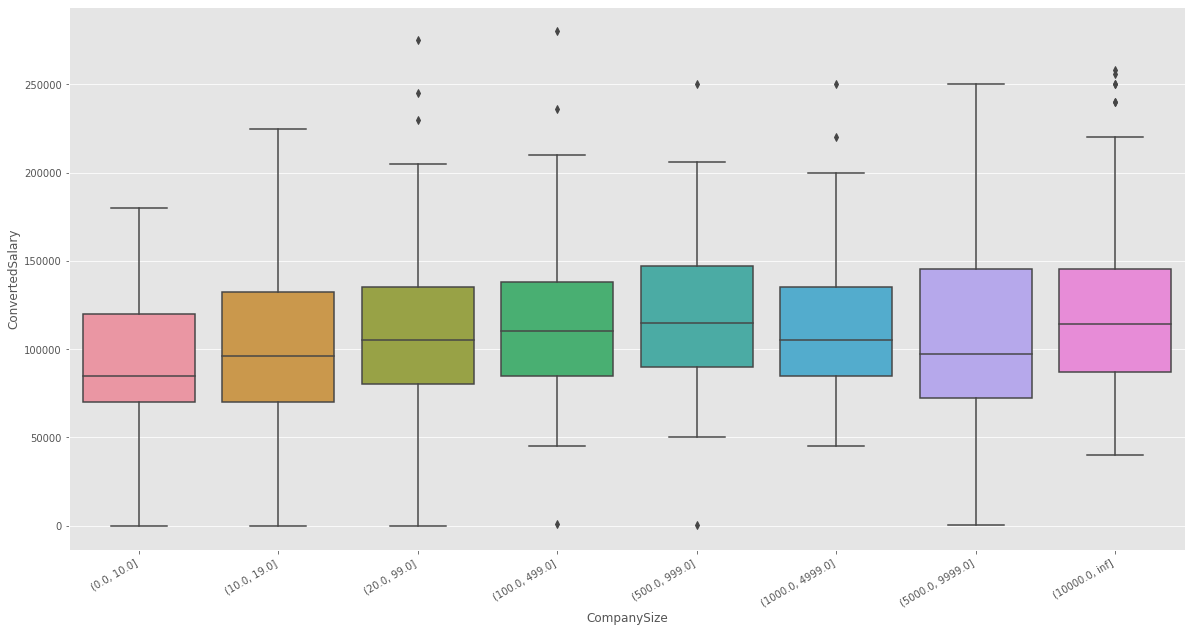

<IPython.core.display.Javascript object>

In [344]:
sns.boxplot(
    data=ml,
    x="CompanySize",
    y="ConvertedSalary",
)
plt.xticks(rotation=30, ha="right")
plt.show()

## Salary by Company Size and Years Coding

In [345]:
size_sorted["YearsCoding > 10"] = size_sorted["YearsCoding"].apply(
    lambda row: row.right > 10 if isinstance(row, pd.Interval) else row
)

<IPython.core.display.Javascript object>

In [346]:
years_sorted["CompanySize > 500"] = years_sorted["CompanySize"].apply(
    lambda row: row.right > 500 if isinstance(row, pd.Interval) else row
)

<IPython.core.display.Javascript object>

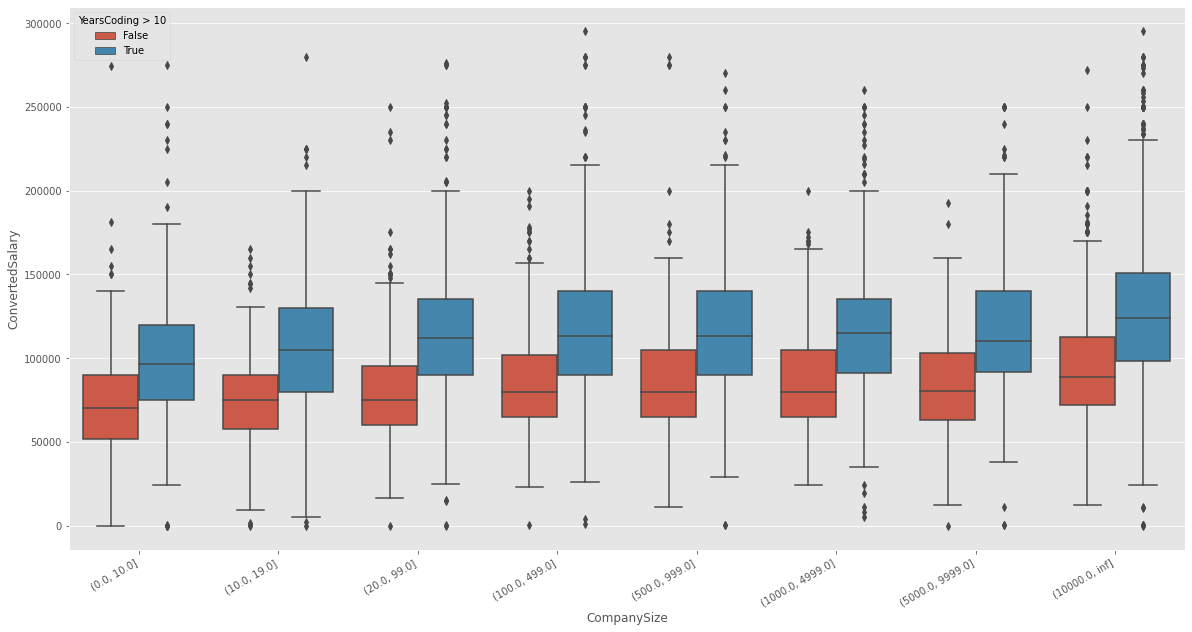

<IPython.core.display.Javascript object>

In [347]:
plt.figure(figsize=(20, 10))
sns.boxplot(
    data=size_sorted, x="CompanySize", y="ConvertedSalary", hue="YearsCoding > 10"
)
plt.xticks(rotation=30, ha="right")
plt.show()

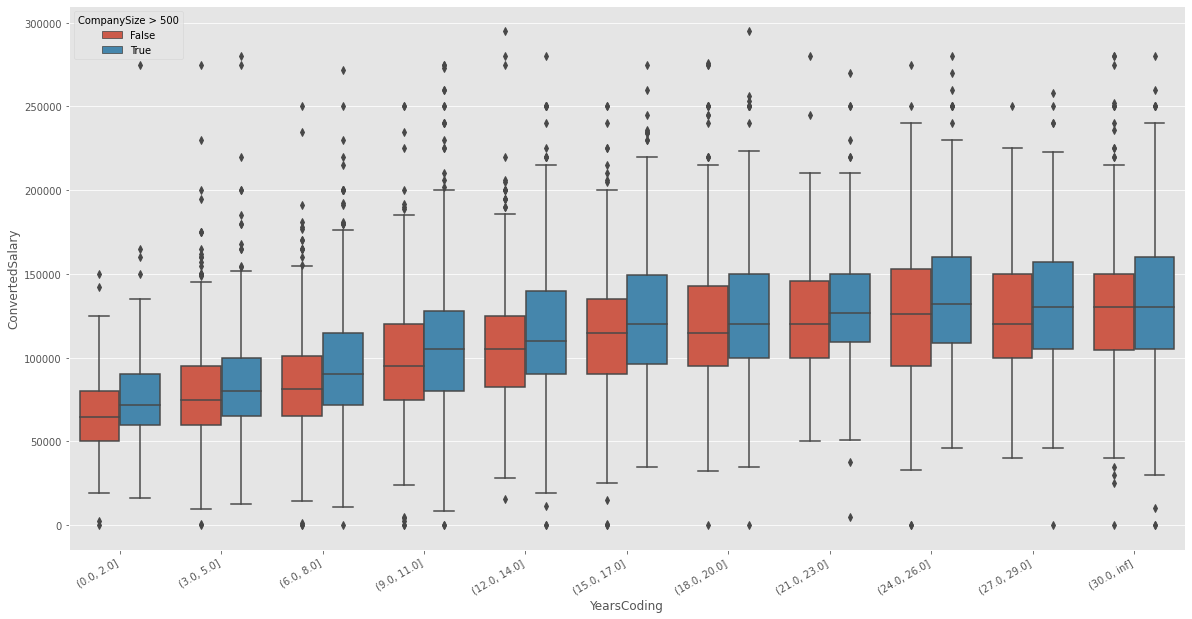

<IPython.core.display.Javascript object>

In [348]:
plt.figure(figsize=(20, 10))
sns.boxplot(
    data=years_sorted, x="YearsCoding", y="ConvertedSalary", hue="CompanySize > 500"
)
plt.xticks(rotation=30, ha="right")
plt.show()

## Salary by Job Satisfaction

In [349]:
ordered_satisfaction = [
    "Extremely dissatisfied",
    "Moderately dissatisfied",
    "Slightly dissatisfied",
    "Neither satisfied nor dissatisfied",
    "Slightly satisfied",
    "Moderately satisfied",
    "Extremely satisfied",
]

normal_salary.JobSatisfaction = normal_salary.JobSatisfaction.astype("category")
normal_salary.JobSatisfaction.cat.set_categories(
    ordered_satisfaction, ordered=True, inplace=True
)

sort_by_satisfaction = normal_salary.dropna(
    subset=["ConvertedSalary", "JobSatisfaction"]
).sort_values(by="JobSatisfaction")

/home/khuyen/Data-science/venv/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


<IPython.core.display.Javascript object>

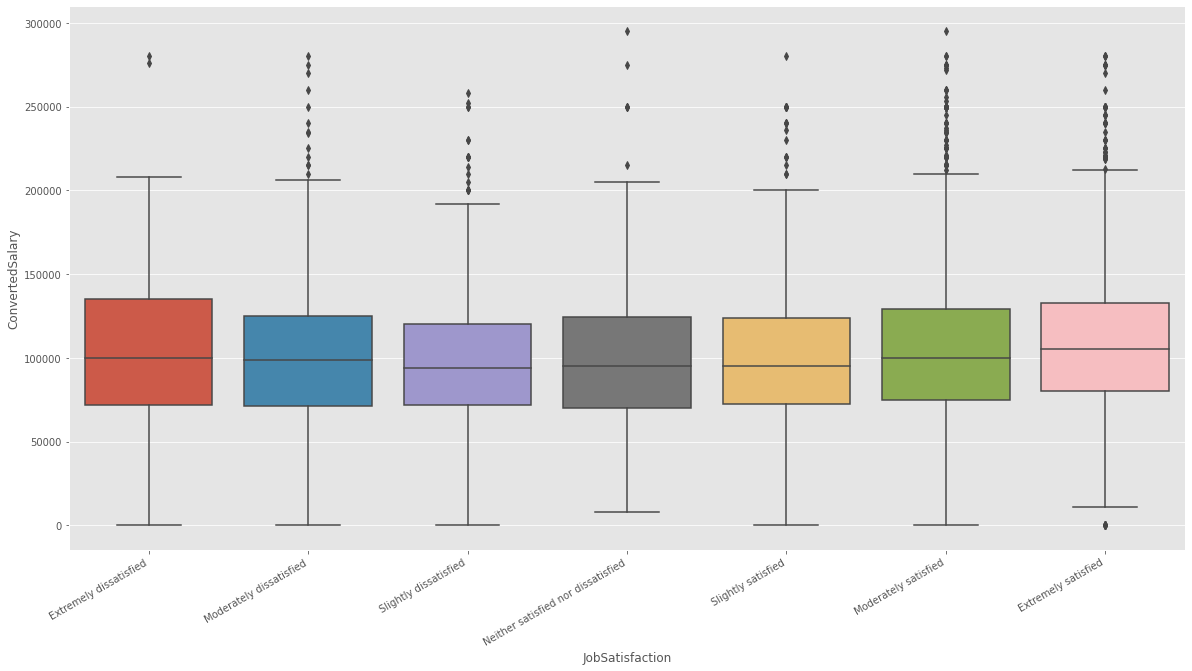

<IPython.core.display.Javascript object>

In [350]:
sns.boxplot(data=sort_by_satisfaction, x="JobSatisfaction", y="ConvertedSalary")
plt.xticks(rotation=30, ha="right")
plt.show()